In [1]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

### short-term demand elasticity

In [3]:
simulation_week0 = WeeklySimulation(start_week, lr, T0_pricing_params)

In [4]:
simulation_week0.set_short_term_demand_elasticity(price_per_mile=4, elasticity=1)

/Users/davidliu/Desktop/Python312/reinforcement_learning_for_rideshare_pricing/notebooks/../ridesharing_simulation.py:118: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  b_r_solution = fsolve(equation_to_solve, initial_guess)


array([-17.17246877])

In [5]:
simulation_week0.set_short_term_demand_elasticity(price_per_mile=3, elasticity=1)

array([-18.11508512])

In [6]:
simulation_week0.set_short_term_demand_elasticity_log_space(price_per_mile=np.log(4), elasticity=1)

/Users/davidliu/Desktop/Python312/reinforcement_learning_for_rideshare_pricing/notebooks/../ridesharing_simulation.py:141: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  b_r_solution = fsolve(equation_to_solve, initial_guess)


array([0.88667647])

In [7]:
simulation_week0.set_short_term_demand_elasticity_log_space(price_per_mile=np.log(3), elasticity=1)

/Users/davidliu/Desktop/Python312/reinforcement_learning_for_rideshare_pricing/notebooks/../ridesharing_simulation.py:141: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  b_r_solution = fsolve(equation_to_solve, initial_guess)


array([1.11873455])

In [8]:
# Given values
E = 1
a_r = 0.25  # example value for a_r
price = 20
miles = 5

# Define the function f(b_r) to find the root
def f(b_r):
    P = 1 / (1 + np.exp(-(a_r + b_r * (price / miles))))
    return (E * miles / ((1 - P) * price)) - b_r

# Initial guess for b_r
initial_guess = -0.01

# Solve for b_r
b_r_solution = fsolve(f, initial_guess)

print(f"Estimated value of b_r: {round(b_r_solution[0], 4)}")

Estimated value of b_r: -0.0621


/var/folders/sg/52_wwpld14z_lvc4rf4zy9x00000gn/T/ipykernel_67617/2377351255.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  b_r_solution = fsolve(f, initial_guess)


### validate by plotting the acceptance prob. vs price

### do we need a fix b_r or solve it for every price(that's too slow, may bucket the price and pre-compute the corresponding b_r)

In [4]:
for b_r in [-0.1, -0.05, -0.01, 0.01, 0.05, 0.1]:
    simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
    simulation_this_week.b_r = b_r
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()
        simulation_this_week.request_driver_matching(verbose=1, file_prefix='b_r_'+str(b_r))
        simulation_this_week.update_gamma_distns()

In [52]:
b_r = -0.2
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [33]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_b_r_0.1.log", lines=True)

In [34]:
matchde_trips_week_0_df['distance_normalized_price'].describe()

count    1756.000000
mean        4.655028
std         0.882624
min         3.780000
25%         4.090000
50%         4.350000
75%         4.825000
max         8.330000
Name: distance_normalized_price, dtype: float64

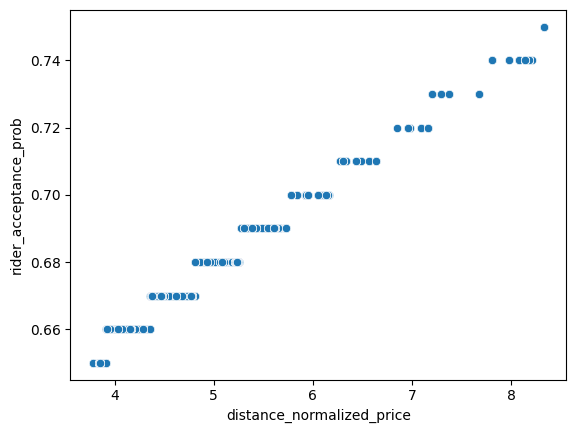

In [35]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

### it is obviously mistaken(for self.b_r>0), as the rider's acceptance prob should be negatively related to distance_normalized_price

In [36]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])

In [37]:
slope, intercept, r_value, p_value, std_err

(0.020850308448795922,
 0.5743193526017079,
 0.9875351161976194,
 0.0,
 7.934995123921441e-05)

In [38]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_b_r_-0.1.log", lines=True)

In [39]:
matchde_trips_week_0_df['distance_normalized_price'].describe()

count    13428.000000
mean         4.648324
std          0.861814
min          3.760000
25%          4.100000
50%          4.350000
75%          4.860000
max          8.330000
Name: distance_normalized_price, dtype: float64

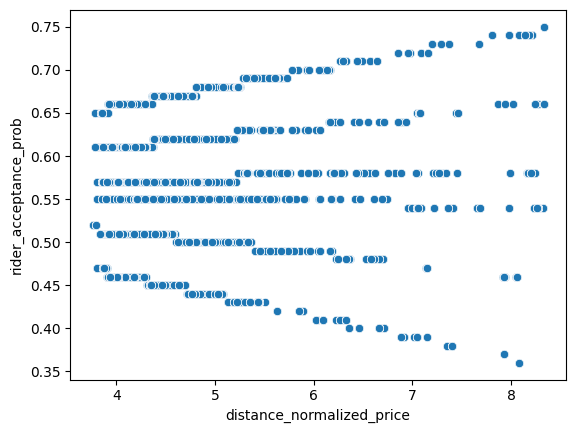

In [40]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [41]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])

In [42]:
slope, intercept, r_value, p_value, std_err

(0.0056385827612853885,
 0.551532073962373,
 0.06990236135296982,
 5.08705373906048e-16,
 0.0006944502441862463)

In [44]:
matchde_trips_week_0_df[matchde_trips_week_0_df.rider_acceptance_prob<0.5]['trip_duration'].describe()

count    1332.000000
mean        9.346847
std         5.516300
min         1.000000
25%         4.000000
50%         9.000000
75%        14.000000
max        22.000000
Name: trip_duration, dtype: float64

In [46]:
matchde_trips_week_0_df[matchde_trips_week_0_df.rider_acceptance_prob>0.65]['trip_duration'].describe()

count    3010.000000
mean        9.997674
std         4.468976
min         1.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        20.000000
Name: trip_duration, dtype: float64

In [47]:
matchde_trips_week_0_df[matchde_trips_week_0_df.rider_acceptance_prob<0.5]['ride_miles'].describe()

count    1332.000000
mean        4.677545
std         2.750316
min         0.290000
25%         2.170000
50%         4.400000
75%         6.990000
max        11.200000
Name: ride_miles, dtype: float64

In [48]:
matchde_trips_week_0_df[matchde_trips_week_0_df.rider_acceptance_prob>0.65]['ride_miles'].describe()

count    3010.000000
mean        4.997023
std         2.238724
min         0.280000
25%         3.370000
50%         5.085000
75%         6.750000
max         9.830000
Name: ride_miles, dtype: float64

In [116]:
a_r = 0.2
b_r = -0.02
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [117]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_0.2_b_r_-0.02.log", lines=True)

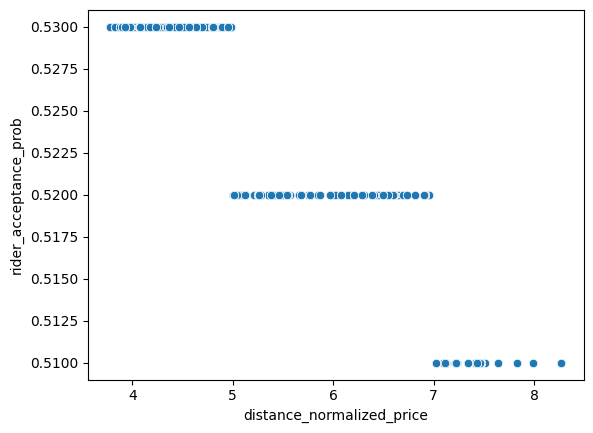

In [118]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [119]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])

In [120]:
slope, intercept, r_value, p_value, std_err

(-0.005357451210683513,
 0.5523665649692886,
 -0.924960393669947,
 0.0,
 6.0521730644162724e-05)

### as in above, the rider's acceptance prob on avg. decreases 0.5% for every 1 unit increase of distance_normalized_price.The scatter plot for the demand curve is then  composed to  negative step-wise horizotal lines and the range may be too small to be reflective in real accepts

In [129]:
a_r = 0.2
b_r = -0.04
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [130]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_0.2_b_r_-0.04.log", lines=True)

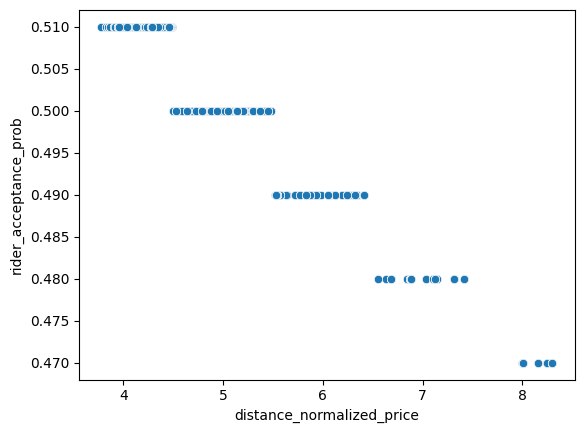

In [131]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [132]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.009827930911705472,
 0.5498589909298668,
 -0.9626890627817791,
 0.0,
 7.383391028611407e-05)

In [78]:
a_r = 1
b_r = -0.2
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [79]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_1_b_r_-0.2.log", lines=True)

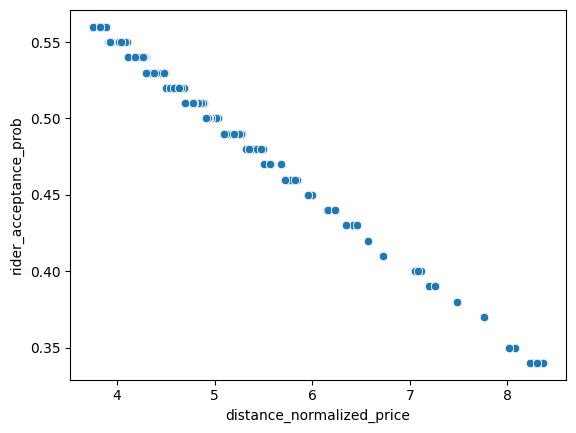

In [80]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [81]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.04942453373794647,
 0.7474274122422868,
 -0.9973198516976438,
 0.0,
 0.00010351160866683296)

### as in the above regression, short-term demand elasticity is around -0.05, which could be more realistic, otherwise the acceptance prob for riders will have a very small standard deviation

In [94]:
a_r = 1.5
b_r = -0.2
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [95]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_1.5_b_r_-0.2.log", lines=True)

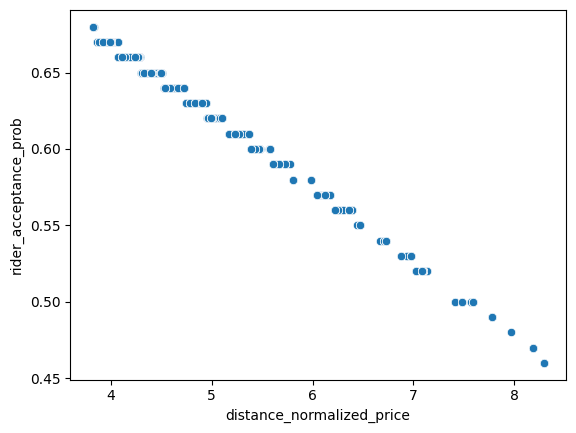

In [96]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [97]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.04739771167144178,
 0.858266485419996,
 -0.99767025445221,
 0.0,
 8.600868849038364e-05)

### as a_r increases from 1 to 1.5(while keeping b_r=-0.2), the range of rider's acceptance prob changes from (0.35,0.55) to (0.45, 0.65)

In [125]:
a_r = 2.5
b_r = -0.4
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r))
    simulation_this_week.update_gamma_distns()

In [126]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_2.5_b_r_-0.4.log", lines=True)

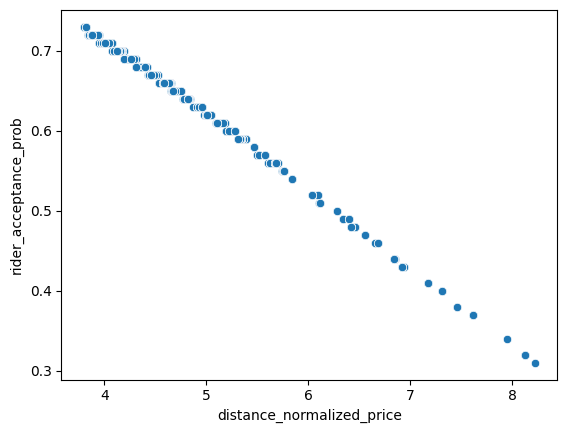

In [127]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [128]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.09335786547733746,
 1.0863672855812405,
 -0.9984045907347809,
 0.0,
 0.00013627988624646066)

### roughly if we double the b_r, the elasticity coeff will double as well, the range of rider_acceptance_prob will increase as we increase b_r

### tune driver's short-term elasticity

In [134]:
a_r = 1.5
b_r = -0.2
a_d = 0.25
b_d = -0.005
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
simulation_this_week.b_d = b_d
simulation_this_week.a_d = a_d
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r)+'_a_d_'+str(a_d)+'_b_d_'+str(b_d))
    simulation_this_week.update_gamma_distns()

In [135]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_1.5_b_r_-0.2_a_d_0.25_b_d_-0.005.log", lines=True)

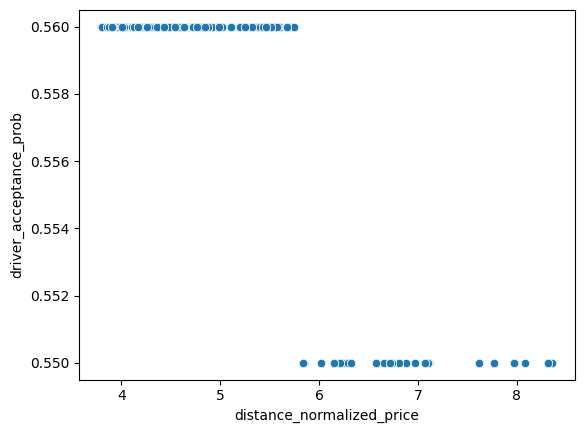

In [136]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='driver_acceptance_prob')
plt.show()

In [137]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['driver_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.002495576957696023,
 0.5706923689531219,
 -0.8039040350494405,
 2.186443113e-314,
 4.964742313579807e-05)

In [165]:
a_r = 1.5
b_r = -0.2
a_d = 1.5
b_d = -0.2
simulation_this_week = WeeklySimulation(start_week, lr, T0_pricing_params)
simulation_this_week.b_r = b_r
simulation_this_week.a_r = a_r
simulation_this_week.b_d = b_d
simulation_this_week.a_d = a_d
for d in range(7):
    drivers_this_week_today = simulation_this_week.simulate_supply()
    requests_this_week_today = simulation_this_week.simulate_demand()
    simulation_this_week.request_driver_matching(verbose=1, file_prefix='a_r_'+str(a_r)+'_b_r_'+str(b_r)+'_a_d_'+str(a_d)+'_b_d_'+str(b_d))
    simulation_this_week.update_gamma_distns()

In [166]:
matchde_trips_week_0_df = pd.read_json("../data/1_week_elasticity/logfile_matched_trips_week_0_a_r_1.5_b_r_-0.2_a_d_1.5_b_d_-0.2.log", lines=True)

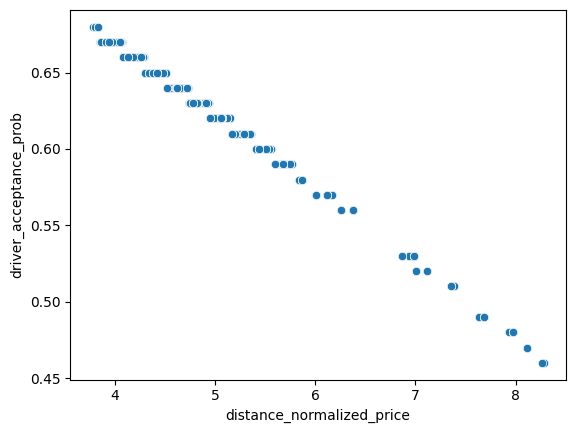

In [167]:
sns.scatterplot(data=matchde_trips_week_0_df, x='distance_normalized_price', y='driver_acceptance_prob')
plt.show()

In [168]:
slope, intercept, r_value, p_value, std_err = linregress(matchde_trips_week_0_df['distance_normalized_price']
                                                         , matchde_trips_week_0_df['driver_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.047206436318055885,
 0.8576105627117224,
 -0.9969130989629775,
 0.0,
 8.910159212440368e-05)